# Forest elephant vocalisation call-type classification

This Jupyter notebook provides a step-by-step guide to using unsupervised deep learning techniques to classify forest elephant vocalisation call-types and evaluate the performance of these techniques. In this notebook, we take a datset containing three different forest elephant vocalisations and use the unsupervised techniques to automatically extract the acoustic features, project these high-dimensional features into lower dimensional space and evaluate how well these methods have been able to distinguish the call-types. 

## Dataset Description

The call-type dataset contains audio files of African forest elephants recorded by the Elephant Listening Project in the Dzanga-Bai clearing in the the southwestern Central African Republic between September 2018 and April 2019. It has 1254 rows each representing an elephant vocalisation with the start time, end time, low frequency and high frequency annotated alongside the call-type (roar, rumble or trumpet).

## Steps
1. **Set-up** Import the libraries and functions needed to conduct the analysis.
2. **Audio pre-processing**: Pre-process the data to isolate the vocalisations and clean them up for feature extraction. 
3. **Feature extraction**: extract the acoustic features using a pre-trained Convolutional Neural Network.
4. **Dimensionality reduction**: Project the acoustic features into 2D space to visualise the call-type classifications.
5. **Silhouette analysis**: Calculate the silhouette scores for the UMAP acoustic feature embeddings.
6. **Call-Type Classification**: Train a random forest classifier and assess its classification performance.

### 1. Set-up

Here we will import a series of pre-defined scripts used to automate the import of the libraries needed for each of the aforementioned steps. These are all located in the "elephant_scripts" folder in the main project repository.

In [1]:
%run elephant_scripts/import_libraries

# Step 1: run the script for the vocalisation dataset 
%run elephant_scripts/load_data

# Step 2 & 3: load the functions needed for audio pre-processing and feature extraction
%run elephant_scripts/feature_extraction

# Step 4: load the functions needed for dimensionality reduction
%run elephant_scripts/umap_projections

# Step 5: load the functions to calculate and visualise silhouette scores for the statistical analysis
%run elephant_scripts/silhouette_score

# enable plots to be auto-displayed in the notebook
%matplotlib inline 


2024-09-16 15:21:10.226908: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 15:21:10.228892: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 15:21:10.254318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 15:21:10.800905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Main libraries successfully imported
Info file loaded: /home/alastair/forestdata/alastair/temp/elephant_analysis_repository/data/1.elephant_call_type_df.csv
Audio file paths added to DataFrame
Vocalisation Dataset successfully loaded
Functions for Audio Pre-processing and Feature Extraction successfully loaded
Functions for Dimensionality Reduction successfully loaded
Functions for Statistical Analysis successfully imported


In [2]:
# Visualise the vocalisation dataset
df

,filename,recording_id,start_time,end_time,duration,low_freq,high_freq,Call-Type,Behavioural_context,Combination,audio_filepaths
0,opp_542_ru1.wav,121,0.174116,1.005954,0.831838,1.245117,1957.397461,Roar,Affiliation,Combination,/home/alastair/forestdata/alastair/temp/elepha...
1,opp_472_ro1.wav,4,0.875765,1.353111,0.477346,2.026367,1961.547852,Roar,Nursing,Single,/home/alastair/forestdata/alastair/temp/elepha...
2,opp_574_ro.wav,112,4.245421,5.665175,1.419754,2.026367,1994.580078,Roar,Competition,Single,/home/alastair/forestdata/alastair/temp/elepha...
3,opp_647_ru1.wav,227,2.969520,3.698800,0.729280,4.882812,1972.851563,Roar,Separation,Combination,/home/alastair/forestdata/alastair/temp/elepha...
4,opp_394_ro1.wav,13,1.195425,1.726845,0.531420,8.129883,1980.688477,Roar,Competition,Single,/home/alastair/forestdata/alastair/temp/elepha...
...,...,...,...,...,...,...,...,...,...,...,...
1249,opp_495_ru.wav,1235,1.136562,3.769334,2.632772,2.612305,136.523438,Rumble,Competition,Single,/home/alastair/forestdata/alastair/temp/elepha...
1250,opp_793_ru.wav,80,0.981174,1.618347,0.637173,6.591797,134.545898,Rumble,Competition,Single,/home/alastair/forestdata/alastair/temp/elepha...
1251,opp_407_ro.wav,195,5.992237,7.490254,1.498016,1.611328,134.521484,Rumble,Competition,Combination,/home/alastair/forestdata/alastair/temp/elepha...
1252,opp_424_ru.wav,78,2.302418,7.350745,5.048326,0.927734,96.801758,Rumble,Competition,Single,/home/alastair/forestdata/alastair/temp/elepha...


### 2. Audio pre-processing

Now that the dataframe is loaded and associated with the audio files, we need to pre-process the audio files to extract the exact frequency ranges and time periods associated with the vocalisations. This helps to minimise unwanted environmental sound that may cause erroneous results. These are the steps take to pre-process the files and extract their audio features:

<ol type="A">

<li>Read the entire audio file.<li>
Apply a bandpass filter to exclude frequencies outside the vocalisation range using the low_frequency and high_frequency information.<li>
Extract the audio clip corresponding to the vocalisation using the start_time and end_time information.<li>
Zero-pad the vocalisation to a length that is a multiple of 96 (the input size of the VGGish model) and centre the recording within this padding.<li>
Normalise the audio clip to have a peak amplitude of 1 to control for elephant distance from the microphone.<li>
Reapply the bandpass filter to remove any acoustic artifacts that have been introduced by the pre-processing.

To visualise how this audio pre-processing works, we can take a sample file and show the effect of each step in the pre-processing

In [3]:
# Select a random file from the dataframe
sample = df.sample(n=1).iloc[0]

# Print information about the audio file
print(sample)

filename                                                  opp_731_ro.wav
recording_id                                                         775
start_time                                                      1.142483
end_time                                                        5.953776
duration                                                        4.811293
low_freq                                                      133.862305
high_freq                                                    1954.736328
Call-Type                                                           Roar
Behavioural_context                                          Competition
Combination                                                  Combination
audio_filepaths        /home/alastair/forestdata/alastair/temp/elepha...
Name: 111, dtype: object


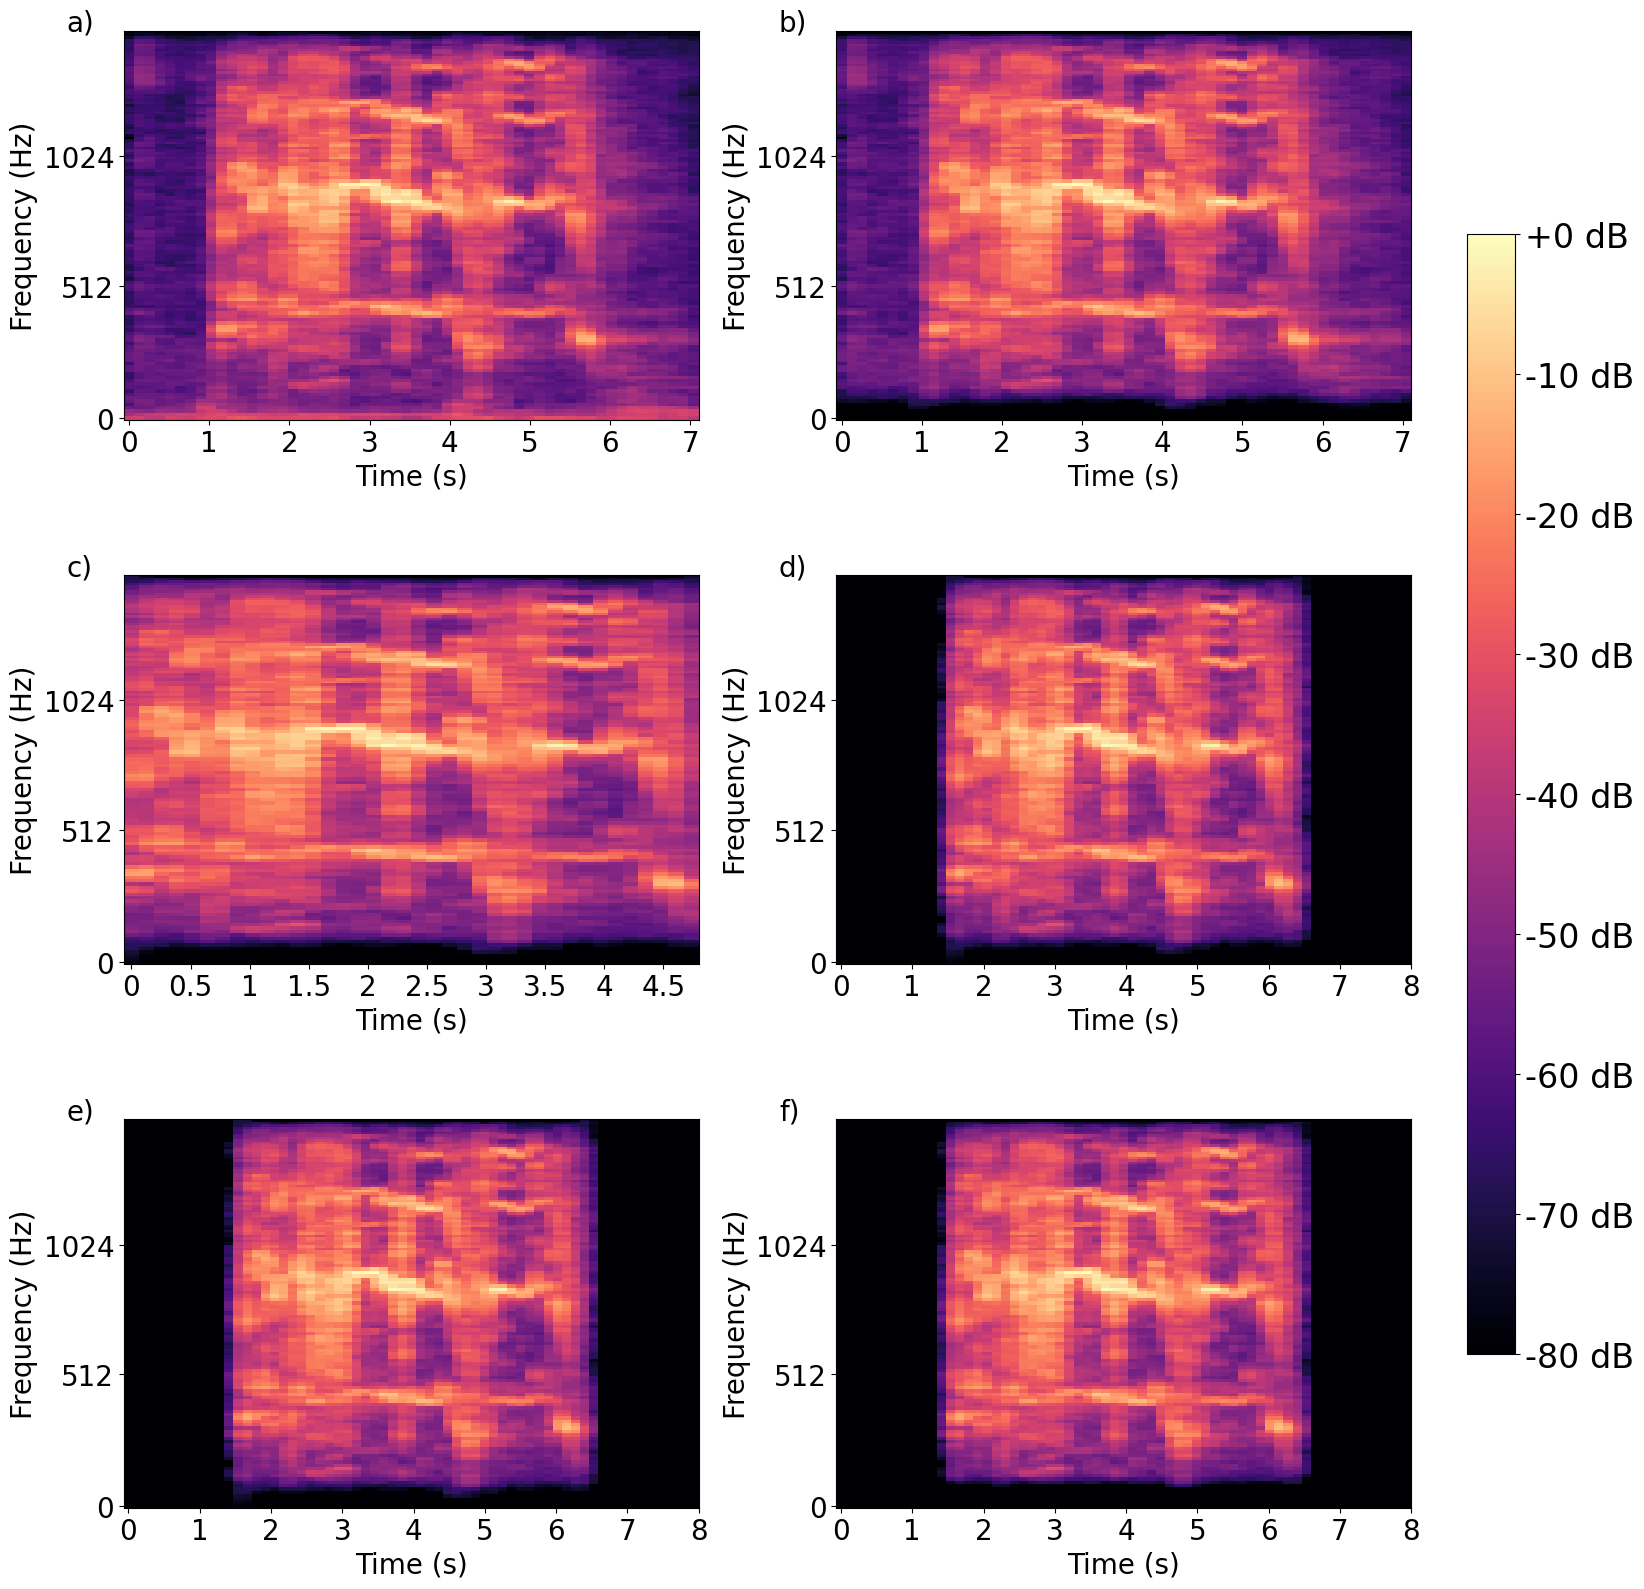

In [4]:
# Set audio parameters used in the functions below
samplerate = DEFAULT_SAMPLERATE
window_size = DEFAULT_WINDOW_SIZE
position = DEFAULT_CLIP_POSITION

# Work through each of the pre-processing steps in turn

# 1) Read audio
wav, sr = read_audio(sample.audio_filepaths)

# 2) Apply bandpass filter
filtered_wav = apply_bandpass_filter(wav, sample.low_freq, sample.high_freq, samplerate)

# 3) Extract audio segment based on annotation times
extracted_audio = extract_audio(filtered_wav, sample, samplerate=samplerate)

# 4) Zero-pad the wav array
padded_wav = zero_pad(sample, window_size, samplerate, extracted_audio)

# 5) Normalise the sound file
normalised_clip = normalise_sound_file(padded_wav)

# 6) Re-apply bandpass filter to the normalised waveform
refiltered_wav = apply_bandpass_filter(normalised_clip, sample.low_freq, sample.high_freq, samplerate)

# Plot spectrograms for each pre-processing step
steps = ['1) Read Audio', '2) Apply Bandpass Filter', '3) Extract Audio', '4) Zero-Pad', '5) Normalise Amplitude', '6) Reapply Bandpass filter']
audios = [wav, filtered_wav, extracted_audio, padded_wav, normalised_clip, refiltered_wav]
plot_spectrograms(steps, audios, sr=samplerate, window_size=window_size, position=position)

These individual steps are combined in one single function called the wav_cookiecutter which we'll use for the pre-processing the rest of the data

### 3. Feature extraction

The pre-processed audio files are then passed through the VGGish pre-trained CNN in 0.96s multiples and their acoustic features are automatically extracted to produce embeddings. These embeddings are then averaged to obtain a single embedding per vocalisation. This feature extraction phase involves the following steps:

1. Extract the acoustic feature embeddings for each 96-sample chunk of the audio clip using the pretrained CNN VGGish.
2. Average the embeddings across the chunks to obtain a single embedding for each vocalisation.
3. Add in information about the duration of each vocalisation

This resulting embedding encodes the acoustic feature representation of the vocalisation.

In [5]:
model = hub.load('https://tfhub.dev/google/vggish/1')

# Extract VGGish features
results = []
for _, annotation in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    # Apply the wav_cookiecutter function combining all of the audio
    # pre-processing steps
    wav = wav_cookiecutter(
        annotation,
        window_size=window_size,
        position="middle",
        samplerate=samplerate,
    )

    embeddings = model(wav)
    assert embeddings.shape[1] == 128  # Check the number of features per frame

    # Store info of the embeddings of each frame
    for embedding in embeddings:
        results.append(
            {
                "recording_id": annotation.recording_id,
                **{f"feature_{n}": feat for n, feat in enumerate(embedding)},
            }
        )
results = pd.DataFrame(results)

# average vggish annotation feature vectors back into original # of annotations
results = results.groupby("recording_id").mean()

# Add in the missing duration information as the 129th feature
duration = df[["recording_id", "duration"]].copy()
results = results.join(duration.set_index("recording_id"))

results

Processing: 100%|██████████| 1254/1254 [01:21<00:00, 15.41it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,duration
recording_id,,,,,,,,,,,,,,,,,,,,,
1,-0.515972,-0.945503,0.477771,-0.668821,-0.57095,-0.932322,-0.636771,-0.477236,-0.554,-0.025346,...,-0.184155,0.176045,0.129956,-0.311545,-0.098671,-0.591734,-0.887841,-0.081387,-0.589816,2.146929
2,-0.307767,-0.092635,0.276705,-0.187101,0.268155,-0.458426,-0.131895,-0.070607,-0.025204,-0.393817,...,-0.12714,-0.123594,-0.055394,-0.178481,0.020661,-0.082918,-0.417923,0.137096,-0.313308,0.517146
3,-0.167978,-0.245697,0.404217,-0.207483,-0.175113,-0.335954,-0.198125,-0.103949,-0.382519,-0.161365,...,-0.124672,0.177732,-0.220059,0.020245,0.133535,0.006519,-0.115893,0.09173,-0.229476,1.042779
4,-0.384921,-0.216846,0.39587,0.060304,0.079169,-0.448791,-0.223726,-0.132696,-0.156767,-0.39375,...,-0.25844,-0.010367,-0.148642,-0.149439,-0.001076,-0.07927,-0.499473,0.177549,-0.326151,0.477346
5,-0.244848,0.106207,0.084387,0.010487,-0.006746,-0.389433,-0.174722,0.098153,-0.535595,-0.011508,...,0.189568,-0.086625,-0.023329,-0.222726,-0.059364,-0.074564,-0.431752,-0.016367,0.107249,4.722631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,-0.73037,-0.318896,0.231963,-0.0481,-0.000253,-0.296795,-0.138244,-0.104653,-0.503284,-0.485252,...,0.014706,-0.012054,-0.083158,0.033577,-0.013438,-0.290914,-0.599987,0.283681,-0.190117,0.924552
1253,-0.221255,-0.191392,0.365925,-0.066978,0.110305,-0.479004,-0.294852,-0.021371,-0.220296,-0.172582,...,-0.104506,-0.035295,-0.26214,-0.151623,0.140103,0.080468,-0.398714,-0.138962,-0.290984,0.341624
1254,-0.613267,-0.209866,0.203842,0.091372,0.112618,-0.296297,-0.063837,0.019286,-0.242869,-0.283673,...,0.135368,-0.185478,-0.018262,-0.158814,0.065845,-0.181922,-0.54809,0.430584,-0.163478,0.504992


In [6]:
# Save the extracted acoustic features to a csv file
results.to_csv(os.path.join(os.path.sep, DATA, 'acoustic_features.csv'))

### 4. Dimensionality reduction

Now that we have the 129D embeddings for each of the 1254 recordings we need to reduce this high-dimensional data into lower dimensional space to make it interpretable to the human brain and usable in the statistical tests. This involves 4 steps:
1. Specify the parameters for the dimensionality reduction, including the number of components (2) and distance metric we want to use (cosine)
2. Normalise the 129D embeddings so that their mean = 0 and variance = 1. This ensures equal weighting of the features
3. Carry out the dimensionality reduction
4. Visualise the results to enable observation of clustering

In [7]:
# Load the saved acoustic features
results = pd.read_csv(os.path.join(os.path.sep, DATA, 'acoustic_features.csv'))

In [8]:
# Specify the UMAP parameters
results_df = results # name of the dataframe where the embeddings are contained
metadata_df = df # name of the dataframe where the call-type labels are contained
N_COMP = 2 # select 1, 2 or 3 dimensions
metric = 'cosine' # distance metric used
n_neighbors = 15
min_dist = 0
random_state = 2204

In [9]:
# Normalise the extracted acoustic features
scaler = StandardScaler()
normalised = scaler.fit(results_df)
normalised_df = pd.DataFrame(scaler.transform(results_df), columns = results_df.columns, index = results_df.index)
normalised_df = normalised_df.set_index("recording_id")
normalised_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,duration
recording_id,,,,,,,,,,,,,,,,,,,,,
-1.731289,-0.912539,-3.469207,0.586230,-1.577812,-3.375247,-2.313763,-2.634366,-2.407735,-0.544476,0.886060,...,-1.651988,0.923479,1.628321,-1.684613,-1.234323,-3.043567,-2.631176,-0.816349,-2.210517,0.192205
-1.728530,0.177136,0.591914,-0.269403,0.211791,2.116715,-0.079225,0.062523,-0.037715,1.325232,-1.215871,...,-1.258729,-0.901633,0.302119,-0.687203,-0.427416,0.476845,-0.116217,0.490689,-0.720135,-1.079671
-1.725771,0.908747,-0.136926,0.273224,0.136072,-0.784480,0.498257,-0.291257,-0.232051,0.061845,0.110143,...,-1.241706,0.933757,-0.876083,0.802399,0.335822,1.095651,1.500222,0.219292,-0.268277,-0.669469
-1.723013,-0.226661,0.000453,0.237703,1.130906,0.879801,-0.033794,-0.428006,-0.399600,0.860053,-1.215489,...,-2.164363,-0.211961,-0.365086,-0.469507,-0.574399,0.502089,-0.552666,0.732692,-0.789356,-1.110730
-1.720254,0.506432,1.538740,-1.087814,0.945835,0.317481,0.246094,-0.166243,0.945893,-0.479401,0.964994,...,0.925734,-0.676454,0.531548,-1.018849,-0.968533,0.534649,-0.190232,-0.427381,1.546677,2.202272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.719906,-2.034629,-0.485480,-0.459804,0.728184,0.359977,0.682903,0.028608,-0.236152,-0.365156,-1.737457,...,-0.280361,-0.222240,0.103464,0.902333,-0.657987,-0.962242,-1.090610,1.367607,-0.056129,-0.761733
1.722665,0.629912,0.121657,0.110273,0.658050,1.083581,-0.176257,-0.807943,0.249256,0.635430,0.046159,...,-1.102612,-0.363802,-1.177178,-0.485879,0.380235,1.607286,-0.013413,-1.160787,-0.599807,-1.216647
1.725424,-1.421747,0.033689,-0.579471,1.246326,1.098723,0.685252,0.426067,0.486223,0.555616,-0.587561,...,0.551895,-1.278571,0.567802,-0.539782,-0.121890,-0.208142,-0.812860,2.246430,0.087456,-1.089155


In [10]:
# Function to fit UMAP and return the embedding
import umap.umap_ as umap

def fit_umap(normalised_df, N_COMP, metric, min_dist, n_neighbors, random_state):
    reducer = umap.UMAP(n_components=N_COMP, metric=metric, min_dist=min_dist, n_neighbors = n_neighbors, random_state=random_state)
    return reducer.fit_transform(normalised_df)

# Fit UMAP and obtain embeddings
embedding = fit_umap(normalised_df, N_COMP, metric, min_dist, n_neighbors, random_state)

results = pd.DataFrame(
    {
        "recording_id": results_df["recording_id"],
        **{f"UMAP{i + 1}": embedding[:, i] for i in range(N_COMP)},
    }
)

# Merge UMAP coordinates with metadata
umap_df = merge_metadata(results, metadata_df)

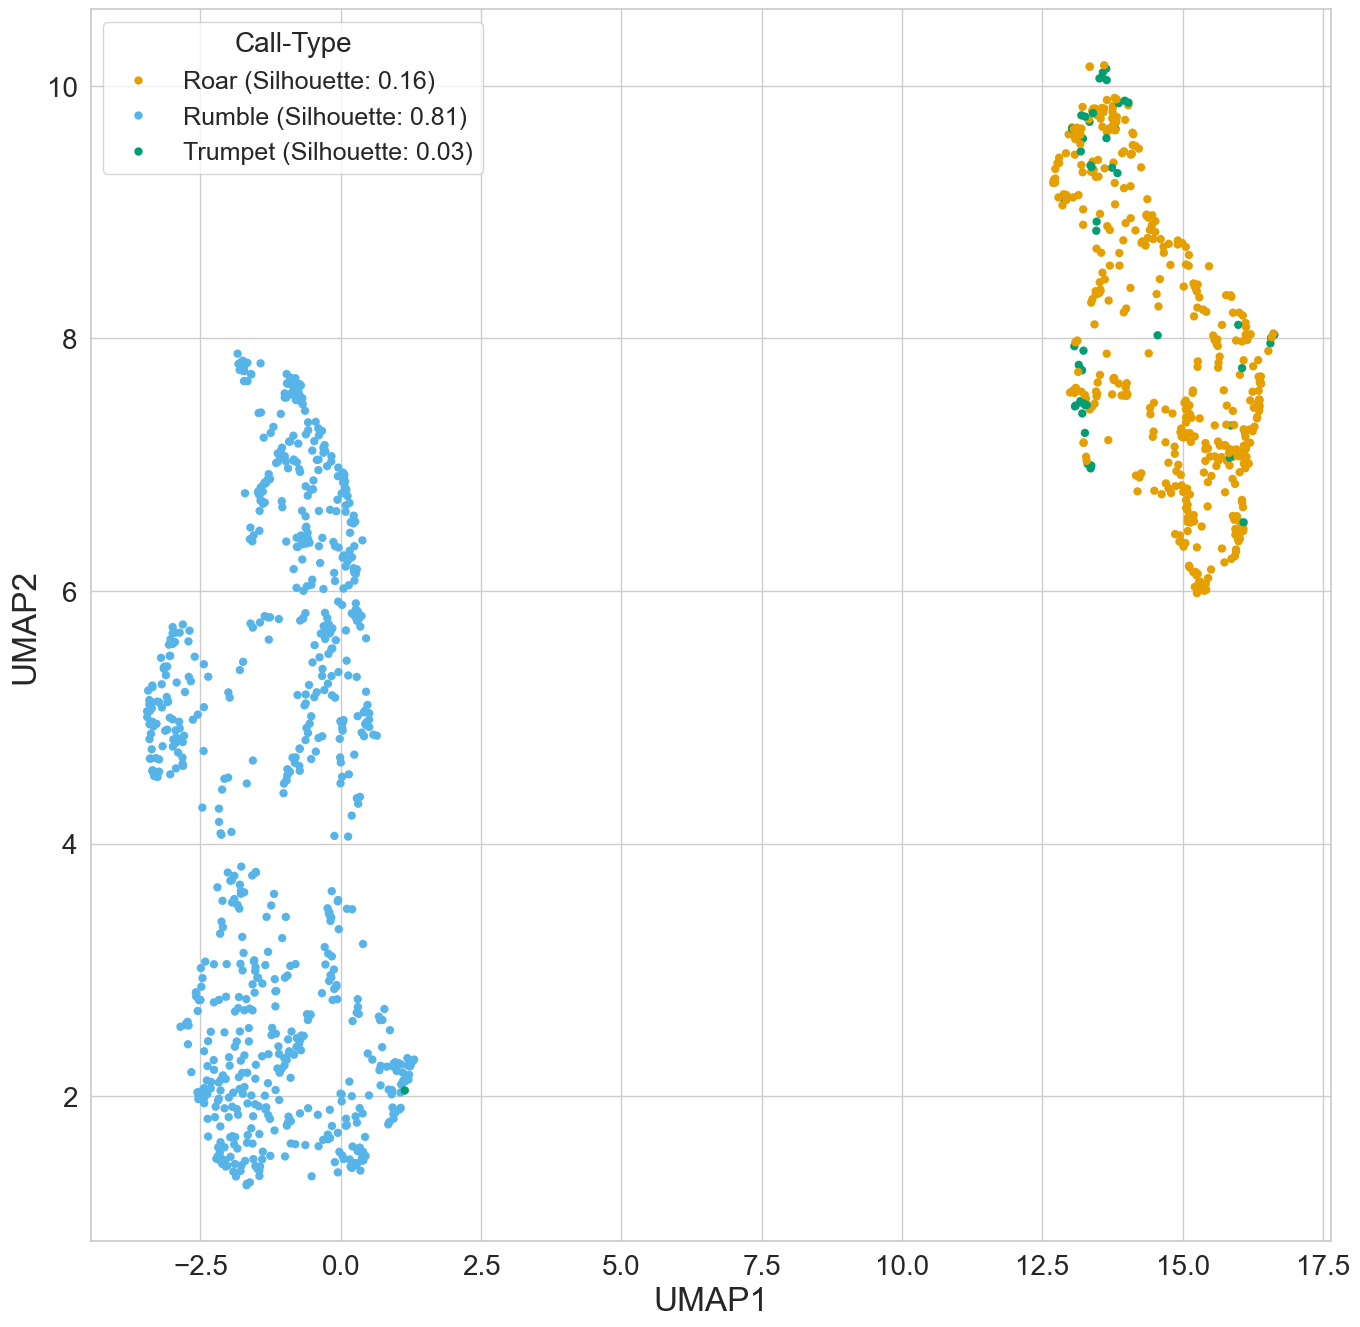

In [11]:
# Set the style of the visualisation
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 16))

# Define a colour-blind friendly palette with three colors
colorblind_palette = ["#E69F00", "#56B4E9", "#009E73"]

# Calculate silhouette scores
labels = umap_df['Call-Type']
silhouette_avg = silhouette_score(umap_df[['UMAP1', 'UMAP2']], labels)
silhouette_values = silhouette_samples(umap_df[['UMAP1', 'UMAP2']], labels)

# Prepare a dictionary to store average silhouette scores for each label
silhouette_dict = {}
unique_labels = labels.unique()
for label in unique_labels:
    label_indices = (labels == label)
    avg_silhouette_score = silhouette_values[label_indices].mean()
    silhouette_dict[label] = avg_silhouette_score

# Create a scatter plot with the custom colour-blind friendly palette
scatter_plot = sns.scatterplot(
    x=umap_df['UMAP1'],
    y=umap_df['UMAP2'],
    hue=umap_df['Call-Type'],
    palette=colorblind_palette,
    edgecolor='none' 
)

# Set the title, labels, parameters
scatter_plot.set_xlabel('UMAP1', fontsize=24)
scatter_plot.set_ylabel('UMAP2', fontsize=24)
scatter_plot.tick_params(axis='x', labelsize=20)
scatter_plot.tick_params(axis='y', labelsize=20)

# Update legend labels to include silhouette scores
handles, labels = scatter_plot.get_legend_handles_labels()
new_labels = []
for label in labels:
    if label in silhouette_dict:
        new_label = f'{label} (Silhouette: {silhouette_dict[label]:.2f})'
        new_labels.append(new_label)
    else:
        new_labels.append(label)

scatter_plot.legend(handles=handles, labels=new_labels, title='Call-Type', title_fontsize='20', fontsize='18', loc='best')

# Show the plot
plt.show()


### 5. Silhouette analysis

We can visually assess the level of separation achieved by the unsupervised methods but this needs to be accompanied by a statistical analysis of its performance. We will do this by calculating the overall silhouette score for the data and the silhouette score per call-type.

The silhouete score is a mathematical representation of the tightness and separation of each cluster (Rousseeuw, 1987). It is calculated as the mean Euclidean distance between data points within a cluster (a) and the mean Euclidean distance to points in the nearest cluster (Rousseeuw, 1987).

Typically, silhouette scores >=0.5 show evidence for clustering, while those >=0.7 show strong evidence for clustering.

In [12]:
# Define data and embeddings 
embeddings = umap_df[['UMAP1', 'UMAP2']].values
labels = umap_df['Call-Type'].values

# Calculate the overall silhouette score for the whole vocalisation dataset
silhouette_scores_obj = SilhouetteScores(embedding=embeddings, labels=labels)
avrg_score = silhouette_scores_obj.get_avrg_score()
print("Average Silhouette Score:", avrg_score)

# Calculate the silhouette score per call-type
scores_per_class = silhouette_scores_obj.get_score_per_class()
for label, score in zip(silhouette_scores_obj.labeltypes, scores_per_class):
    print("Label:", label, "Silhouette Score:", score)

Average Silhouette Score: 0.5591406
Label: Roar Silhouette Score: 0.16335147619247437
Label: Rumble Silhouette Score: 0.8099871277809143
Label: Trumpet Silhouette Score: 0.033587049692869186


### 6. Call-Type Classification

Lastly, we use the UMAP acoustic feature embeddings to train a Random Forest Classifier to predict the 3 Call-Types on unseen test data. We perform hyperparameter optimisation on the Random Forest model and cross validation on the resultant model.

In [13]:
# Define a function to handle the model training and evaluation for each category
def train_evaluate_category(X, y, category_name):
    # Define outer cross-validation strategy
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store results
    best_params_list = []
    best_accuracy_list = []

    # Loop through outer cross-validation folds
    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Oversample the minority class using RandomOverSampler with automatic sampling strategy
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

        # Hyperparameter optimization using GridSearchCV (Random Forest parameters)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample']
        }
        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
        grid_search.fit(X_resampled, y_resampled)

        # Store best hyperparameters and accuracy
        best_params_list.append(grid_search.best_params_)
        best_accuracy_list.append(grid_search.best_score_)

        # Print best hyperparameters
        print(f"Best Parameters for {category_name}:", grid_search.best_params_)
        print(f"Best Accuracy for {category_name}:", grid_search.best_score_)

        # Print classification report for the best model
        rf_best = grid_search.best_estimator_
        y_pred_best = rf_best.predict(X_test)
        print(f"Random Forest {category_name} Classification Report:\n", classification_report(y_test, y_pred_best))

    # Return average of best accuracy across folds
    return np.mean(best_accuracy_list)

# Split the filtered datasets into training and testing sets for each category

# Run
X_call, y_call = umap_df[['UMAP1', 'UMAP2']], umap_df['Call-Type']
mean_accuracy_call = train_evaluate_category(X_call, y_call, "Call-Type")
print("Mean accuracy for Call-Type:", mean_accuracy_call)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters for Call-Type: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy for Call-Type: 0.9893162393162394
Random Forest Call-Type Classification Report:
               precision    recall  f1-score   support

        Roar       0.93      0.94      0.94        86
      Rumble       1.00      1.00      1.00       155
     Trumpet       0.50      0.45      0.48        11

    accuracy                           0.96       252
   macro avg       0.81      0.80      0.80       252
weighted avg       0.95      0.96      0.96       252

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters for Call-Type: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy for Call-Type: 0.9919743178170144
Random Forest Call-Type Classificatio